# Utilize `healsparse` to plot cell-coadd statistics

A notebook to plot summary statistics of cell-based coadds, e.g. magnitude depth, variance, input images etc. onto sky plots

Last working weekly: w2024_30

## Load imports and data

In [1]:
REPO = '/sdf/data/rubin/repo/main/'

from lsst.daf.butler import Butler
from pprint import pprint
import lsst.afw.image as afwImage
from lsst.skymap import Index2D
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy.ma as ma
import healsparse as hsp
import healpy as hp
import lsst.geom as afwGeom
import skyproj

%matplotlib inline

butler = Butler(REPO)
registry = butler.registry

# define image display backend
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('firefly')

In [2]:
# collection = 'u/mgorsuch/assemble_cell_coadds_tract_9813/20240624T164450Z' # all working patches in tract 9813
collection = 'u/mgorsuch/assemble_cell_coadds/20240730T204305Z' # all working patches in tract 9813

## Start with a single patch for simplicity

Patches to choose from: [37, 38, 39, 40, 41, 44, 45, 46, 48, 49, 50, 51, 52, 55, 56, 57, 60, 61, 62, 63, 67, 83, 84]

In [142]:
patch = 50

In [143]:
coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=patch,
                     band='i',)

Get the number of visits per cell

In [5]:
cell_list_filled = list(coadd.cells.keys()) # skips indices that are empty, fixed below

In [6]:
# we will need all possible indices to know which ones are zero
# cell_list will store all indices
# cells_filled tracks which ones have inputs
cell_list = []
cells_filled = [False] * 484 # TO-DO: remove hard-coded array shape

index = 0
for i in range(22):
    for j in range(22):
        cell_list.append(Index2D(x=j,y=i))

        for cell in cell_list_filled:
            if (j==cell.x) and (i==cell.y):
                cells_filled[index]=True

        index += 1

Get the number of inputs for each cell, and arrange the values into a 2D grid.

### WCS for cells

Get the WCS information from the coadd

In [3]:
# define a wcs from the given coadd
wcs = coadd.wcs
sky_coord = wcs.pixelToSky(afwGeom.Point2D(0, 0))
print(sky_coord)

NameError: name 'coadd' is not defined

Check that cells contain active WCS information (aka just check that they aren't the same for now)

In [68]:
cell = coadd.cells[cell_list_filled[0]]
cell_other = coadd.cells[cell_list_filled[1]]

In [9]:
cell_center = cell.outer.bbox.getCenter()
cell_center_coord = wcs.pixelToSky(cell_center)
print(cell_center, cell_center_coord)

(17924, 11924) (150.1813697634, +2.0179279192)


In [10]:
cell_center2 = cell_other.outer.bbox.getCenter()
cell_center_coord2 = wcs.pixelToSky(cell_center2)
print(cell_center2, cell_center_coord2)

(18074, 11924) (150.1743654788, +2.0179276178)


Are the distances reasonable, given the size of cells? (~30.91" on a side for inner cells)

In [11]:
# define inner and outer bbox for reference
outer_bbox = cell.outer.bbox
inner_bbox = cell.inner.bbox

In [12]:
# get the four corner coordinates of the cell, both for inner and outer boundaries
outer_corners = [wcs.pixelToSky(outer_bbox.beginX, outer_bbox.beginY),
                 wcs.pixelToSky(outer_bbox.beginX, outer_bbox.endY),
                 wcs.pixelToSky(outer_bbox.endX, outer_bbox.beginY),
                 wcs.pixelToSky(outer_bbox.endX, outer_bbox.endY),]

inner_corners = [wcs.pixelToSky(inner_bbox.beginX, inner_bbox.beginY),
                 wcs.pixelToSky(inner_bbox.beginX, inner_bbox.endY),
                 wcs.pixelToSky(inner_bbox.endX, inner_bbox.beginY),
                 wcs.pixelToSky(inner_bbox.endX, inner_bbox.endY),]

In [13]:
print("Outer RA length: ", outer_corners[0].getRa().asArcseconds()-outer_corners[3].getRa().asArcseconds())
print("Inner RA length: ", inner_corners[0].getRa().asArcseconds()-inner_corners[3].getRa().asArcseconds())
print("Outer DEC length: ", outer_corners[0].getDec().asArcseconds()-outer_corners[3].getDec().asArcseconds())
print("Inner DEC length: ", inner_corners[0].getDec().asArcseconds()-inner_corners[3].getDec().asArcseconds())

Outer RA length:  42.027615871978924
Inner RA length:  25.21656957885716
Outer DEC length:  -41.997669598076754
Inner DEC length:  -25.198601898262496


The 25" seems a little low for my estimate of inner cell size, but it is in the ballpark.

### Collect cell information 

Need the RA, DEC of each cell center, as well as information of interest e.g. input counts, cell depth, cell variance

The cell information of interest should be an array the same shape as the RA and DEC arrays of cell centers.

In [9]:
center_ra = []
center_dec = []
inputs_list = []

# for each cell in cell_list:
for index, cell in enumerate(cell_list):

    # check if the cell is filled, skip if not
    if not (cells_filled[index]):
        continue 

    cell_center = coadd.cells[cell].outer.bbox.getCenter()
    cell_center_coord = wcs.pixelToSky(cell_center)
    center_ra.append(cell_center_coord[0].asDegrees())
    center_dec.append(cell_center_coord[1].asDegrees())
    
    inputs_list.append(coadd.cells[cell].visit_count)

center_ra = np.array(center_ra)
center_dec = np.array(center_dec)
inputs_list = np.array(inputs_list)

In [10]:
patch_coords = np.array([[dec, center_ra[i]] for i, dec in enumerate(center_dec)])
u, c = np.unique(patch_coords, return_counts=True, axis=0)
dup = u[c > 1]
print(len(dup))

0


### Generate a `healsparse` map

In [55]:
# define map parameters
nside_coverage = 2**8
nside_sparse = 2**14

hsp_map = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.int64)

In [56]:
# retrieves the correct pixel locations according to ra and dec
pixels = hp.ang2pix(nside_sparse, np.radians(90 - center_dec), np.radians(center_ra), nest=True)

# map cell inputs to correct pixels
hsp_map.update_values_pix(pixels, inputs_list)

### Plot `healsparse` map

In [64]:
# degrade the map for plotting
hsp_map_low_res = hsp_map.degrade(2**13, reduction='min')

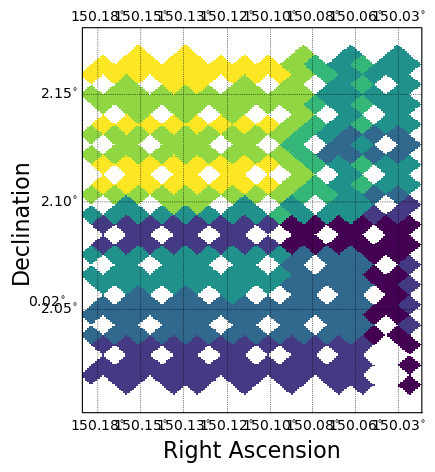

In [65]:
fig, ax = plt.subplots(figsize=(8, 5))
sp = skyproj.GnomonicSkyproj(ax=ax, lon_0=150.1, lat_0=2.1)
sp.draw_hspmap(hsp_map_low_res, lon_range=[150, 151], lat_range=[2.0, 2.2])
plt.show()

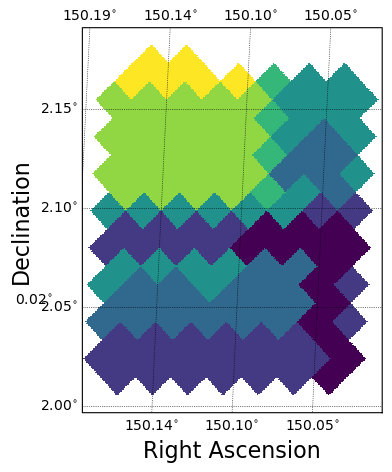

In [38]:
fig, ax = plt.subplots(figsize=(8, 5))
sp = skyproj.MollweideSkyproj(ax=ax)
sp.draw_hspmap(hsp_map_low_res, lon_range=[150, 151], lat_range=[2.0, 2.2])
plt.show()

## Plot Multiple Patches

In [4]:
patches = [37, 38, 39, 40, 41, 44, 45, 46, 48, 49, 50, 51, 52, 55, 56, 57, 60, 61, 62, 63, 67, 83, 84]

In [107]:
def get_cell_variance(cell):
    var_array = cell.inner.variance.array

    # mask cells with only inf/-inf variance
    if (len(var_array[np.isfinite(var_array)]) == 0):
        return np.nan

    median_var = np.median(var_array[np.isfinite(var_array)])

    return median_var

In [130]:
# might be time to switch to a dictionary for cell information
center_ra = []
center_dec = []
inputs_list = []
variance_list = []
mag_depth_list = []

segs = [] # collection of lines to plot patch outlines

for patch in patches:
    
    coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=patch,
                     band='i',)

    # define a wcs from the given coadd
    wcs = coadd.wcs

    # get coadd outline
    coadd_corners = coadd.inner_bbox.getCorners()

    for index, corner in enumerate(coadd_corners):
        corner_coord_start = wcs.pixelToSky(corner.getX(), corner.getY())
        if index < 3:
            corner_coord_end = wcs.pixelToSky(coadd_corners[index+1].getX(), coadd_corners[index+1].getY())
        else:
            corner_coord_end = wcs.pixelToSky(coadd_corners[0].getX(), coadd_corners[0].getY())

        start_ra = corner_coord_start[0].asDegrees()
        start_dec = corner_coord_start[1].asDegrees()

        end_ra = corner_coord_end[0].asDegrees()
        end_dec = corner_coord_end[1].asDegrees()

        segs.append(((start_ra, start_dec), (end_ra, end_dec)))
    
    cell_list = list(coadd.cells.keys()) # skips indices that are empty

    # for each cell in cell_list:
    for index, cell_index in enumerate(cell_list):

        cell = coadd.cells[cell_index]
    
        cell_center = cell.outer.bbox.getCenter()
        cell_center_coord = wcs.pixelToSky(cell_center)
        center_ra.append(cell_center_coord[0].asDegrees())
        center_dec.append(cell_center_coord[1].asDegrees())
        
        inputs_list.append(cell.visit_count)
        variance_list.append(get_cell_variance(cell))

    del coadd

center_ra = np.array(center_ra)
center_dec = np.array(center_dec)
inputs_list = np.array(inputs_list)
variance_list = np.array(variance_list)

Now that this is iterating over multiple patches that overlap, there will be duplicate cells that will be to be ignored.

TO-DO: check if duplicate cells have the same number of inputs

In [137]:
all_coords = np.array([[dec, center_ra[i], inputs_list[i], variance_list[i]] for i, dec in enumerate(center_dec)]) # combine coords into 2D array
# all_coords = np.array([[dec, center_ra[i], inputs_list[i]] for i, dec in enumerate(center_dec)]) # combine coords into 2D array
unique_coords = np.unique(all_coords, axis=0)

In [164]:
# revert back to 1D arrays
center_dec, center_ra, inputs_list, variance_list = np.split(unique_coords,4,axis=1)
# center_dec, center_ra, inputs_list = np.split(unique_coords,3,axis=1)
center_dec = center_dec.flatten()
center_ra = center_ra.flatten()
inputs_list = inputs_list.flatten().astype(np.int64)
variance_list = variance_list.flatten()

In [165]:
print(variance_list.shape)

(4518,)


In [166]:
print(center_ra.shape)
test_ra, counts = np.unique(center_ra, return_counts=True)
dup_ra = test_ra[counts>1]
test_dec, counts = np.unique(center_dec, return_counts=True)
dup_dec = test_dec[counts>1]
print(test_ra.shape)
print(dup_ra, dup_dec)

(4518,)
(4517,)
[149.90115595] [2.21388778]


In [151]:
unique_coords[:, 0]

array([1.996882  , 1.99688367, 1.99688531, ..., 2.47292054, 2.4729212 ,
       2.47292183])

In [163]:
thing = np.where(center_dec==[2.21388778])
print(thing)

(array([], dtype=int64),)


In [105]:
# define map parameters
nside_coverage = 2**8
nside_sparse = 2**14

hsp_map = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.int64)

In [106]:
# retrieves the correct pixel locations according to ra and dec
pixels = hp.ang2pix(nside_sparse, np.radians(90 - center_dec), np.radians(center_ra), nest=True)

# map cell inputs to correct pixels
hsp_map.update_values_pix(pixels, inputs_list)

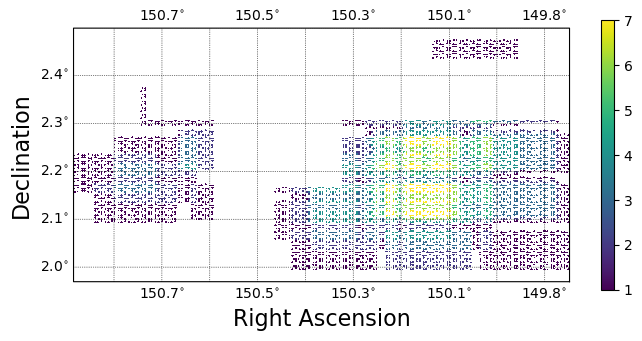

In [80]:
fig, ax = plt.subplots(figsize=(8, 5))
sp = skyproj.GnomonicSkyproj(ax=ax, lon_0=150.1, lat_0=2.1)
sp.draw_hspmap(hsp_map)
# draw patch outlines
# for seg in segs:
#     sp.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.6)
plt.colorbar(shrink=0.7)
plt.show()

In [83]:
hsp_map_low_res = hsp_map.degrade(2**12, reduction='median')

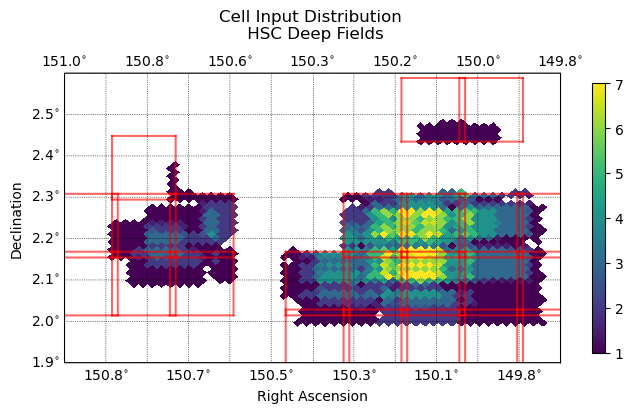

In [84]:
rcparams = {'xtick.labelsize': 10,
            'ytick.labelsize': 10,
            'axes.labelsize': 10,
            'axes.linewidth': 5,}

ln_coll = mpl.collections.LineCollection(segs)

fig, ax = plt.subplots(figsize=(8, 5))

ax.add_collection(ln_coll)
sp = skyproj.GnomonicSkyproj(ax=ax, lon_0=150.4, lat_0=2.2, rcparams=rcparams)

# draw patch outlines
for seg in segs:
    sp.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.6)

sp.draw_hspmap(hsp_map_low_res)
sp.set_extent([149.8, 151, 1.9, 2.6])
plt.colorbar(shrink=0.7)
plt.title(f"Cell Input Distribution \n HSC Deep Fields", pad=25)

plt.show()

### Variance Map

In [94]:
nside_coverage = 2**8
nside_sparse = 2**15

hsp_var_map = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.float64)

pixels = hp.ang2pix(nside_sparse, np.radians(90 - center_dec), np.radians(center_ra), nest=True)
hsp_var_map.update_values_pix(pixels, variance_list)

ValueError: List of pixels must be unique if operation='replace'